# Project work, part 2 - Data Sources

# General

- All project work in **IND320** will result in personal hand-ins and online apps.

1. **A Jupyter Notebook** run locally on your computer (later with access to online and local databases).
   - This will be your basic development and documentation platform.
   - Must include a brief description of **AI usage**.
   - Must include a **300–500 word log** describing the compulsory work (including both Jupyter Notebook and Streamlit experience).
   - Must include **links** to your public **GitHub repository** and **Streamlit app** (see below) for the compulsory work.
   - Document headings should be clear and usable for navigation during development.
   - All code blocks must include enough **comments** to be understandable and reproducible if someone inherits your project.
   - All code blocks must be **run before export to PDF** so messages and plots are shown. In addition, add the `.ipynb` file to the GitHub repository where you have your Streamlit project.

2. **A Streamlit app** running from `https://[yourproject].streamlit.app/`.
   - This will be an online version of the project, accessing data that has been exported to CSV format (later, also an online database).
   - The code, hosted at GitHub, must include relevant comments from the Jupyter Notebook and further comments regarding Streamlit usage.

- There are **four parts** in the project work, building on each other and resulting in a final portfolio and app to be presented at the end of the semester.
- **Co-operation is applauded**, and the use of **AI tools** is encouraged.

# Evaluation

- The uploaded **PDF**, **GitHub repository**, and **Streamlit app** will be assessed according to the recipe above.
  - By one fellow student in **peer review**.
  - By **Liland** or **Kjæreng**.
- TA/Teacher’s feedback will be **short and instructive**, regarding points of improvement and fulfilment of requirements.
- **Final fulfilment** of the course will be based on the **four rounds of hand-ins** seen as a whole.

---

# Tasks


**Here are the links to Streamlit and Github:**
- Streamlit URL: https://ind320-rajvir-7xhejyuxheedg6tbdqwx3h.streamlit.app/
- Github URL: https://github.com/rajern/ind320-rajvir

#### Local database: Cassandra

- If not already done, set up Cassandra and Spark as described in the book.
- Test that your Spark–Cassandra connection works.
- The Cassandra database will be accessed from the Jupyter Notebook and used to store data from the API mentioned later.

(Comment: Make sure to activate .venv and start docker)

In [60]:
import os, sys

# Add environment variables
os.environ["JAVA_HOME"] = r"C:\Users\rajvi\AppData\Local\Programs\Microsoft\jdk-17.0.16.8-hotspot"
os.environ["HADOOP_HOME"] = r"C:\hadoop"

# Ensure Spark uses the Python interpreter from the kernel
os.environ["PYSPARK_PYTHON"] = sys.executable
os.environ["PYSPARK_DRIVER_PYTHON"] = sys.executable

# Add Java and winutils to PATH
os.environ["PATH"] = rf"{os.environ['HADOOP_HOME']}\bin;{os.environ['JAVA_HOME']}\bin;" + os.environ["PATH"]

In [61]:
# Install Cassandra driver
!pip install -q cassandra-driver

In [62]:
# Connect to local Cassandra container
from cassandra.cluster import Cluster
cluster = Cluster(['localhost'], port=9042)
session = cluster.connect()

# Set up new keyspace
session.execute("""
CREATE KEYSPACE IF NOT EXISTS my_first_keyspace
WITH REPLICATION = {'class': 'SimpleStrategy', 'replication_factor': 1};
""")

# Create new table
session.set_keyspace('my_first_keyspace')
session.execute("DROP TABLE IF EXISTS my_first_table;")
session.execute("CREATE TABLE IF NOT EXISTS my_first_table (ind int PRIMARY KEY, company text, model text);")

# Insert data into the table
session.execute("INSERT INTO my_first_table (ind, company, model) VALUES (1, 'Tesla', 'Model 3');")
session.execute("INSERT INTO my_first_table (ind, company, model) VALUES (2, 'Tesla', 'Model Y');")
session.execute("INSERT INTO my_first_table (ind, company, model) VALUES (3, 'Polestar', '2');")

In [63]:
# Start Spark with connector to Cassandra
from pyspark.sql import SparkSession

spark = (
    SparkSession.builder
    .appName("SparkCassandraApp")
    .config("spark.jars.packages", "com.datastax.spark:spark-cassandra-connector_2.12:3.5.1")
    .config("spark.sql.extensions", "com.datastax.spark.connector.CassandraSparkExtensions")
    .config("spark.sql.catalog.mycatalog", "com.datastax.spark.connector.datasource.CassandraCatalog")
    .config("spark.cassandra.connection.host", "localhost")
    .config("spark.cassandra.connection.port", "9042")
    .getOrCreate()
)

In [64]:
# Load the Cassandra table
df = (spark.read.format("org.apache.spark.sql.cassandra")
      .options(table="my_first_table", keyspace="my_first_keyspace")
      .load())
df.show()

# Create SQL view and run simple queries
df.createOrReplaceTempView("my_first_table_view")
spark.sql("SELECT * FROM my_first_table_view").show()
spark.sql("SELECT * FROM my_first_table_view WHERE company='Tesla'").show()

+---+--------+-------+
|ind| company|  model|
+---+--------+-------+
|  2|   Tesla|Model Y|
|  1|   Tesla|Model 3|
|  3|Polestar|      2|
+---+--------+-------+

+---+--------+-------+
|ind| company|  model|
+---+--------+-------+
|  3|Polestar|      2|
|  1|   Tesla|Model 3|
|  2|   Tesla|Model Y|
+---+--------+-------+

+---+-------+-------+
|ind|company|  model|
+---+-------+-------+
|  2|  Tesla|Model Y|
|  1|  Tesla|Model 3|
+---+-------+-------+



#### Remote database: MongoDB

- If not already done, prepare a MongoDB account at [mongodb.com](https://www.mongodb.com).
- Test that you can manipulate data from Python.
- The MongoDB database will store data that has been trimmed/curated/prepared through the Jupyter Notebook and Spark filtering.
- These data will be accessed directly from the Streamlit app.

In [ ]:
# Test MongoDB connection
from pymongo.mongo_client import MongoClient
from pymongo.server_api import ServerApi
import streamlit as st

uri = st.secrets["MONGODB_URI"]

# Create a new client and connect to the server
client = MongoClient(uri, server_api=ServerApi('1'))

# Send a ping to confirm a successful connection
try:
    client.admin.command('ping')
    print("Pinged your deployment. You successfully connected to MongoDB!")
except Exception as e:
    print(e)

Pinged your deployment. You successfully connected to MongoDB!


In [ ]:
# Check that we can manipulate data from python
from pymongo.mongo_client import MongoClient
from pymongo.server_api import ServerApi

uri = st.secrets["MONGODB_URI"]
client = MongoClient(uri, server_api=ServerApi('1'))

db = client["test_db"]
col = db["test_collection"]

# Insert one test document
col.insert_one({"test": "ok"})

# Read it back
print(list(col.find({})))

client.close()

[{'_id': ObjectId('68fa627c523c7983334b0039'), 'test': 'ok'}, {'_id': ObjectId('68fb16576749bf3d2b973bd0'), 'test': 'ok'}, {'_id': ObjectId('68fb1acf6749bf3d2b973bd3'), 'test': 'ok'}, {'_id': ObjectId('68fb28bb14356b602c5cd8c6'), 'test': 'ok'}, {'_id': ObjectId('68fb553014356b602c5cd8c9'), 'test': 'ok'}, {'_id': ObjectId('68fb630e14356b602c5cd8cc'), 'test': 'ok'}, {'_id': ObjectId('68fba6d41f02f734ba223017'), 'test': 'ok'}, {'_id': ObjectId('68fbb67b1f02f734ba22301a'), 'test': 'ok'}, {'_id': ObjectId('68fbb7301f02f734ba22301d'), 'test': 'ok'}, {'_id': ObjectId('68fbc8a91f02f734ba255d81'), 'test': 'ok'}]


#### API

- Familiarise yourself with the API connection at [https://api.elhub.no](https://api.elhub.no).
  - Observe how time is encoded and how transitions between summer and winter time are handled.
  - Be aware of the time period limitations for each API request and how this differs between datasets.

#### Jupyter Notebook

- Use the Elhub API to retrieve hourly production data for all price areas using `PRODUCTION_PER_GROUP_MBA_HOUR` for all days and hours of the year 2021.
  - Extract only the list in `productionPerGroupMbaHour`, convert to a DataFrame, and insert the data into Cassandra using Spark.
  - Use Spark to extract the columns `priceArea`, `productionGroup`, `startTime`, and `quantityKwh` from Cassandra.
- Create the following plots:
  - A pie chart for the total production of the year from a chosen price area, where each piece of the pie is one of the production groups.
  - A line plot for the first month of the year for a chosen price area. Make separate lines for each production group.
- Insert the Spark-extracted data into your MongoDB.
- Remember to fill in the log and AI mentioned in the General section above.

In [67]:
# Fetch data from Elhub API 
import time
import requests
import pandas as pd

# API endpoint
BASE_URL = "https://api.elhub.no/energy-data/v0/price-areas"
DATASET = "PRODUCTION_PER_GROUP_MBA_HOUR"  # API dataset name

def month_ranges(year: int):
    """Yield (start_date, end_date) for each month of given year as YYYY-MM-DD strings."""
    months = pd.date_range(f"{year}-01-01", f"{year}-12-31", freq="MS")
    for start in months:
        end = (start + pd.offsets.MonthEnd(1)).normalize()
        yield start.date().isoformat(), end.date().isoformat()

all_records = []
for start_date, end_date in month_ranges(2021):
    params = {
        "dataset": DATASET,
        "startDate": start_date,   # YYYY-MM-DD
        "endDate": end_date        # YYYY-MM-DD
    }
    print(f"Fetching {start_date} → {end_date} ...")
    resp = requests.get(BASE_URL, params=params, timeout=60)
    resp.raise_for_status()
    payload = resp.json()

    # Extract the inner list with hourly rows
    for item in payload.get("data", []):
        rows = item["attributes"].get("productionPerGroupMbaHour", [])
        all_records.extend(rows)

    # To keep within API rate limits
    time.sleep(0.2)

# Convert API response to DataFrame
df_raw = pd.DataFrame(all_records)

# Quick sanity check
print("-"*75)
print(f"Rows: {len(df_raw)}")
print(df_raw.head())


Fetching 2021-01-01 → 2021-01-31 ...
Fetching 2021-02-01 → 2021-02-28 ...
Fetching 2021-03-01 → 2021-03-31 ...
Fetching 2021-04-01 → 2021-04-30 ...
Fetching 2021-05-01 → 2021-05-31 ...
Fetching 2021-06-01 → 2021-06-30 ...
Fetching 2021-07-01 → 2021-07-31 ...
Fetching 2021-08-01 → 2021-08-31 ...
Fetching 2021-09-01 → 2021-09-30 ...
Fetching 2021-10-01 → 2021-10-31 ...
Fetching 2021-11-01 → 2021-11-30 ...
Fetching 2021-12-01 → 2021-12-31 ...
---------------------------------------------------------------------------
Rows: 208248
                     endTime            lastUpdatedTime priceArea  \
0  2021-01-01T01:00:00+01:00  2024-12-20T10:35:40+01:00       NO1   
1  2021-01-01T02:00:00+01:00  2024-12-20T10:35:40+01:00       NO1   
2  2021-01-01T03:00:00+01:00  2024-12-20T10:35:40+01:00       NO1   
3  2021-01-01T04:00:00+01:00  2024-12-20T10:35:40+01:00       NO1   
4  2021-01-01T05:00:00+01:00  2024-12-20T10:35:40+01:00       NO1   

  productionGroup  quantityKwh                  star

In [68]:
# Keep only the required columns
df_clean = df_raw[["priceArea", "productionGroup", "startTime", "quantityKwh"]].copy()

# Parse startTime as UTC and drop tz info (Cassandra expects naive UTC)
df_clean["startTime"] = pd.to_datetime(df_clean["startTime"], utc=True).dt.tz_localize(None)

# Check the data
print(df_clean.dtypes)
print(df_clean.head())
print(df_clean.tail())

priceArea                  object
productionGroup            object
startTime          datetime64[ns]
quantityKwh               float64
dtype: object
  priceArea productionGroup           startTime  quantityKwh
0       NO1           hydro 2020-12-31 23:00:00    2507716.8
1       NO1           hydro 2021-01-01 00:00:00    2494728.0
2       NO1           hydro 2021-01-01 01:00:00    2486777.5
3       NO1           hydro 2021-01-01 02:00:00    2461176.0
4       NO1           hydro 2021-01-01 03:00:00    2466969.2
       priceArea productionGroup           startTime  quantityKwh
208243       NO5            wind 2021-12-30 18:00:00          0.0
208244       NO5            wind 2021-12-30 19:00:00          0.0
208245       NO5            wind 2021-12-30 20:00:00          0.0
208246       NO5            wind 2021-12-30 21:00:00          0.0
208247       NO5            wind 2021-12-30 22:00:00          0.0


In [69]:
# Set up Cassandra keyspace and table for Elhub data
from cassandra.cluster import Cluster

KEYSPACE = "elhub2021"
TABLE = "prod_by_group_hour"

# Connect to local Cassandra
session = Cluster(["localhost"], port=9042).connect()

# Create keyspace and table if they don't exist
session.execute("""
CREATE KEYSPACE IF NOT EXISTS elhub2021
WITH REPLICATION = {'class':'SimpleStrategy','replication_factor':1};
""")
session.set_keyspace(KEYSPACE)
session.execute("""
CREATE TABLE IF NOT EXISTS prod_by_group_hour (
  pricearea text,
  productiongroup text,
  starttime timestamp,
  quantitykwh double,
  PRIMARY KEY ((pricearea, productiongroup), starttime)
) WITH CLUSTERING ORDER BY (starttime ASC);
""")
print("Cassandra table ready")

Cassandra table ready


In [70]:
# Write data to Cassandra using Spark
df_spark = spark.createDataFrame(df_clean).toDF("pricearea","productiongroup","starttime","quantitykwh")
(df_spark.write
  .format("org.apache.spark.sql.cassandra")
  .options(keyspace=KEYSPACE, table=TABLE)
  .mode("append")
  .save())

print("Data written to Cassandra.")

Data written to Cassandra.


In [71]:
# Read data from Cassandra
KEYSPACE = "elhub2021"
TABLE = "prod_by_group_hour"

df_read = (
    spark.read
    .format("org.apache.spark.sql.cassandra")
    .options(keyspace=KEYSPACE, table=TABLE)
    .load()
)
# Print the schema and show some rows
df_read.printSchema()
df_read.show(5, truncate=False)

root
 |-- pricearea: string (nullable = false)
 |-- starttime: timestamp (nullable = true)
 |-- productiongroup: string (nullable = true)
 |-- quantitykwh: double (nullable = true)

+---------+-------------------+---------------+-----------+
|pricearea|starttime          |productiongroup|quantitykwh|
+---------+-------------------+---------------+-----------+
|NO1      |2020-12-31 23:00:00|hydro          |2507716.8  |
|NO1      |2020-12-31 23:00:00|other          |0.0        |
|NO1      |2020-12-31 23:00:00|solar          |6.106      |
|NO1      |2020-12-31 23:00:00|thermal        |51369.035  |
|NO1      |2020-12-31 23:00:00|wind           |937.072    |
+---------+-------------------+---------------+-----------+
only showing top 5 rows



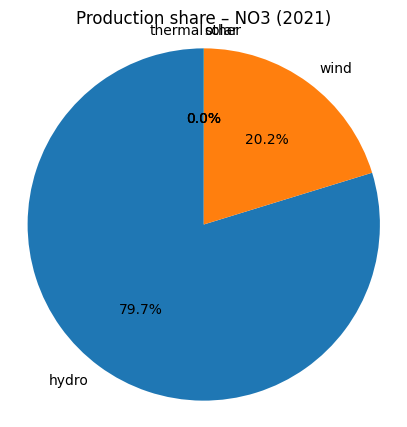

In [72]:
# Pie chart for area NO3
AREA = "NO3"
from pyspark.sql import functions as F
import matplotlib.pyplot as plt

# aggregate kWh per production group for the chosen area
by_group = (df_read
            .filter(F.col("pricearea") == AREA)
            .groupBy("productiongroup")
            .agg(F.sum("quantitykwh").alias("kwh")))

pdf = by_group.toPandas().sort_values("kwh", ascending=False)

plt.figure(figsize=(5,5))
plt.pie(pdf["kwh"], labels=pdf["productiongroup"], autopct="%1.1f%%", startangle=90)
plt.title(f"Production share – {AREA} (2021)")
plt.axis("equal")
plt.show()

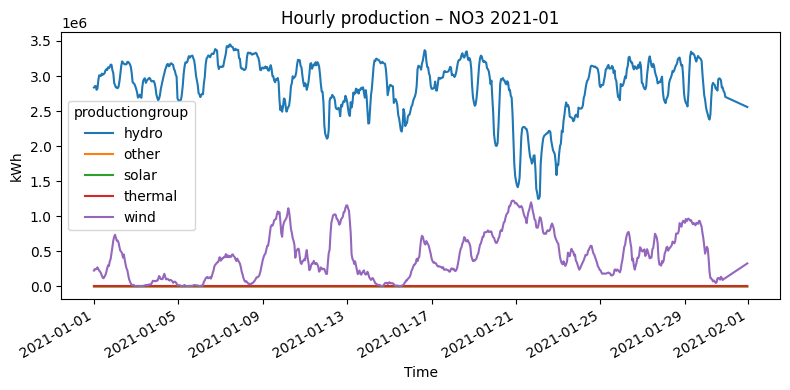

In [73]:
# Line plot for January for area NO3, one line per production group

AREA = "NO3"
YEAR = 2021
MONTH = 1

from pyspark.sql import functions as F
import matplotlib.pyplot as plt

# Aggregate per hour and group
jan = (df_read
       .filter((F.col("pricearea")==AREA) &
               (F.year("starttime")==YEAR) &
               (F.month("starttime")==MONTH))
       .groupBy("starttime","productiongroup")
       .agg(F.sum("quantitykwh").alias("kwh")))

pdf = jan.toPandas()
if pdf.empty:
    print(f"No data for {AREA} {YEAR}-{MONTH:02d}")
else:
    pivot = pdf.pivot(index="starttime", columns="productiongroup", values="kwh").sort_index()
    plt.figure(figsize=(8,4))
    pivot.plot(ax=plt.gca())
    plt.title(f"Hourly production – {AREA} {YEAR}-{MONTH:02d}")
    plt.xlabel("Time")
    plt.ylabel("kWh")
    plt.tight_layout()
    plt.show()


In [ ]:
# Insert Spark-extracted data into MongoDB
import os
from pymongo import MongoClient
from pymongo.server_api import ServerApi

df_pd = df_read.toPandas()
records = df_pd.to_dict(orient="records")

# Connect to MongoDB
uri = st.secrets["MONGODB_URI"]
client = MongoClient(uri, server_api=ServerApi('1'))
client.admin.command("ping")

db = client["elhub2021"]
col = db["production_per_group_hour"]
col.delete_many({})        
col.insert_many(records)   
print(f"Inserted {len(records)} rows from Cassandra into MongoDB.")

client.close()

Inserted 208224 rows from Cassandra into MongoDB.


#### Streamlit app

- Update your Streamlit app from part 1 of the project according to the following points.
- If you have something you would like to keep on page four, move it to a new page five.
- Establish a connection with your MongoDB database. When running this at [streamlit.io](https://streamlit.io), remember to copy your secrets to the webpage instead of exposing them on GitHub.
- On page four, split the view into two columns using `st.columns`.
  - On the left side, use radio buttons (`st.radio`) to select a price area and display a pie chart like in the Jupyter Notebook.
  - On the right side, use pills (`st.pills`) to select which production groups to include and a selection element of your choice to select a month.
  - Combine the price area, production group(s) and month, and display a line plot like in the Jupyter Notebook (but for any month).
  - Below the columns, insert an expander (`st.expander`) where you briefly document the source of the data shown on the page.

### Work Log:

**Docker, Cassandra, and Spark** 
- To begin, I had to set up Docker. After installing Docker Desktop and enabling WSL integration, I pulled and started a Cassandra container locally. This allowed me to run Cassandra on my machine through Docker, using port 9042 for communication.

- Next, I set up Apache Spark. I installed Java (JDK 17) since Spark requires it, and then created a virtual environment where I installed all the necessary Python packages, including pyspark and cassandra-driver.

- Because this was my first time working with both Cassandra and Spark, I had to spend time understanding how they work individually and how they can be connected. I also learned how Docker functions as a local host and how Spark can communicate with Cassandra through the DataStax Spark Cassandra Connector.

- Using the lecture notes and some back-and-forth testing (including help from AI), I gradually got everything to work together. After some debugging and configuration changes, I successfully established a connection between Spark and Cassandra. I was able to read and write data between them, confirming that the integration worked correctly.

**MongoDB**
- For MongoDB, I followed the instructions from the lecture notes. I created a new user in MongoDB Atlas and then tested the connection using the example code provided.

- Initially, I encountered an error because I had written the connection URI incorrectly — I had included the password inside < > brackets instead of writing it directly. After removing those brackets and using the correct format, the connection worked.

**Jupyter Notebook**
- I used Python and Jupyter Notebook to fetch energy production data from the Elhub API for 2021. I cleaned the data to keep only the most relevant columns and stored it in Cassandra using Spark. Then I read the data back from Cassandra and inserted it into MongoDB. Finally, I created simple visualizations — a pie chart showing production share for one area and a line chart for January, displaying hourly production for each production group.
- For this part I had to collaborate with another student, which helped, but this was still my original work. 

**Streamlit app**
- In this part, I created a simple Streamlit web app to visualize the data stored in MongoDB.
I reused most of the structure from Assignment 1 but added a new page called Production explorer.
This page connects to my MongoDB database using the URI stored in secrets.toml, and shows two plots:
a pie chart of total production by group for 2021 and a line chart of hourly production per month.

### AI Usage (brief):


**Docker, Cassandra, and Spark** 
- I used AI a lot back and forth just to understand how Docker, Cassandra and Spark worked together. Also better understanding the lecture notes and the code written there, which I used directly when creating the tests. I encountered a lot of errors at this stage so I used AI to do debugging, which was helpful. 

**MongoDB**
- Since I just followed the instructions it mostly went well. When I encountered the password error AI managed to help me resolve that issue. 

**Jupyter Notebook**
- Used AI to write code more efficiently + debugging when encountering issues. 

**Streamlit app**
- Used AI to help me write the code in 4_Production Explorer.py. 